In [22]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from sklearn import linear_model
from sklearn import model_selection

In [2]:
start_date = datetime(2017, 9, 9)
end_date = datetime(2021, 9, 9)

In [3]:
# Create Point for Boise, ID
boise = Point(43.5667, -116.2333, 871)

# Get daily data for 2018
data = Daily(boise, start_date, end_date)
data = data.fetch()
data["willRain"] = data["prcp"].apply(lambda val: 1 if val >= 0.1 else 0).astype(float)
data['wdir'] = data['wdir'].astype(float)
data['snow'] = data['snow'].astype(float)
data['wpgt'] = data['wpgt'].astype(float)
data['tsun'] = data['tsun'].astype(float)
data['pres'] = data['pres'].astype(float)
data = data.drop('tsun', 1)
data = data.drop('wpgt', 1)
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,willRain
time,,,,,,,,,
2017-09-09,25.7,20.6,31.7,0.0,0.0,NaN,7.9,1011.7,0.0
2017-09-10,23.5,15.0,31.7,0.0,0.0,NaN,9.0,1017.6,0.0
2017-09-11,22.9,14.4,32.2,0.0,0.0,NaN,5.0,1017.9,0.0
2017-09-12,24.7,17.2,31.7,0.0,0.0,NaN,7.9,1012.4,0.0
2017-09-13,24.6,18.9,30.6,0.0,0.0,NaN,11.5,1007.7,0.0
...,...,...,...,...,...,...,...,...,...
2021-09-05,23.1,12.8,33.9,0.0,0.0,121.6,7.9,1014.2,0.0
2021-09-06,23.7,13.3,32.8,0.0,0.0,56.0,9.7,1015.0,0.0
2021-09-07,24.2,15.6,34.4,0.0,0.0,174.0,9.4,1015.9,0.0


In [4]:
'''Number of rows that are null'''
data.isnull().sum()

tavg          0
tmin          0
tmax          0
prcp          0
snow          0
wdir        259
wspd          0
pres         33
willRain      0
dtype: int64

In [5]:
'''Drop all rows that are null'''
data.dropna(inplace = True)
data.isnull().sum()

tavg        0
tmin        0
tmax        0
prcp        0
snow        0
wdir        0
wspd        0
pres        0
willRain    0
dtype: int64

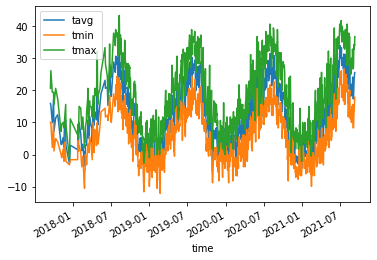

In [6]:
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

Convert dataframe to CSV file

In [7]:
data.to_csv('weather.csv', index=True)

In [8]:
col_names = ['date', 'temp avg', 'temp min', 'temp max', 'precipitation', 'snow', 'wind dir', 'wind speed', 'air pressure', 'willRain']
weather = pd.read_csv("weather.csv", header = None, names=col_names)
weather = weather.iloc[1: , :]

In [9]:
weather['date'] = pd.to_datetime(weather['date'])
weather['temp avg'] = weather['temp avg'].astype(float)
weather['temp min'] = weather['temp min'].astype(float)
weather['temp max'] = weather['temp max'].astype(float)
weather['precipitation'] = weather['precipitation'].astype(float)
weather['snow'] = weather['snow'].astype(float)
weather['wind dir'] = weather['wind dir'].astype(float)
weather['wind speed'] = weather['wind speed'].astype(float)
weather['air pressure'] = weather['air pressure'].astype(float)
weather['willRain'] = weather['willRain'].astype(float)

weather.dtypes

date             datetime64[ns]
temp avg                float64
temp min                float64
temp max                float64
precipitation           float64
snow                    float64
wind dir                float64
wind speed              float64
air pressure            float64
willRain                float64
dtype: object

In [10]:
'''The minimum temperature average can be negative, need to convert to farhenheit'''
weather['temp avg'].min()

-7.9

In [11]:
'''Converts all three average, minimum, maximum temperatures from celsius to farhenheit'''
weather['temp avg'] = weather.apply(lambda x: ((9/5)*x['temp avg'])+32,axis=1)
weather['temp min'] = weather.apply(lambda x: ((9/5)*x['temp min'])+32,axis=1)
weather['temp max'] = weather.apply(lambda x: ((9/5)*x['temp max'])+32,axis=1)

In [12]:
weather.mean()

temp avg           54.441902
temp min           43.168707
temp max           66.144904
precipitation       0.916264
snow                2.193495
wind dir          210.681902
wind speed         12.093745
air pressure     1016.276981
willRain            0.240200
dtype: float64

We found in the weather.mean() command that only 24% of the days in our dataset actually rain. So if you were taking a guess for one day, you would most likely guess that 75% of the days there will be no rain in Boise.

In [13]:
feature_names = ['temp avg', 'temp min', 'temp max', 'wind dir', 'wind speed', 'air pressure']
label = ['willRain']
X = weather[feature_names] # features
Y = weather.willRain       # label

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.30, random_state=0)

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=5000)

logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

If the accuracy of our model is actually 84%, that would mean that it is only slightly better than a guess if we follow the previous calculations that roughly only 24% of the days in Boise will rain based on our dataset. It is likely that with more data, that percentage would be even lower. 

In [17]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8305555555555556


Using the kfold evaluation model, the accuracy across 10 folds is roughly around 83% for the HW4 model created. I will use this number as my starting point for my HW5 Feature Engineering assignment to determine whether the data is greater than 5%. 

In [24]:
kfold = model_selection.KFold(n_splits=10)
model_kfold = LogisticRegression(max_iter=5000)
results_kfold = model_selection.cross_val_score(model_kfold, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0))

Accuracy: 82.82%


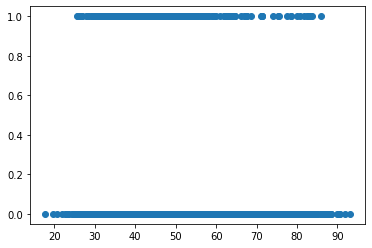

In [18]:
plt.scatter(X['temp avg'], Y)
plt.show()

[]

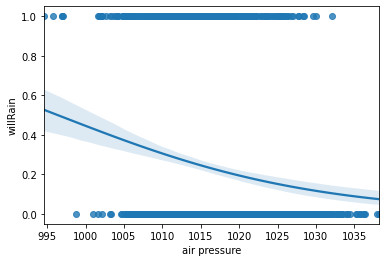

In [19]:
import seaborn as sns
sns.regplot(x = "air pressure", y = "willRain", data = weather, logistic=True)
plt.plot()

I will now attempt to compute the coefficient importance for each of the features. Below, air pressure exhibits almost zero importance which could be largely due to the minimal variance between days that it rained and days in which it didn't rain. Minimum temperature was found to be the only feature that had a relatively large importance in comparison to the rest of the features. 

Text(0.5, 0, 'Importance')

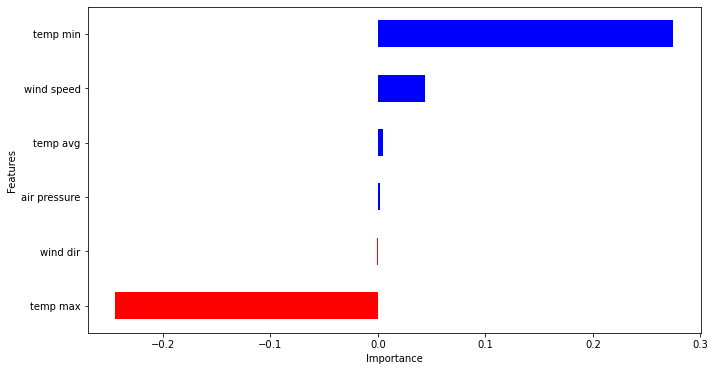

In [20]:
'''Coefficients'''
coeff = list(logreg.coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')